In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gaborfodor_keras_pretrained_models_path = kagglehub.dataset_download('gaborfodor/keras-pretrained-models')
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')


100%|██████████| 943M/943M [00:07<00:00, 136MB/s]

Extracting files...


100%|██████████| 15.1M/15.1M [00:00<00:00, 61.8MB/s]

Extracting files...


Data source import complete.


**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**author**: Ruslan Klymentiev

**date**: 10th June, 2019

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a>
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>
    - <a href='#build'>4.2. Model Building</a>
    - <a href='#perf'>4.3. Model Performance</a>
- <a href='#concl'>5. Conclusions</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [2]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [4]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [5]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


In [20]:
IMG_PATH = (r'/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset/yes/')
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    # Skip hidden files and directories like '.ipynb_checkpoints'
    if not CLASS.startswith('.') and not os.path.isfile(os.path.join(IMG_PATH, CLASS)):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            # Skip hidden files and directories within class folders
            if not FILE_NAME.startswith('.'):
                img = IMG_PATH + CLASS + '/' + FILE_NAME
                if n < 5:
                    # Create destination directory if it doesn't exist
                    dest_dir = os.path.join('TEST', CLASS.upper())
                    os.makedirs(dest_dir, exist_ok=True)

                    shutil.copy(img, os.path.join(dest_dir, FILE_NAME))
                elif n < 0.8*IMG_NUM:
                    # Create destination directory if it doesn't exist
                    dest_dir = os.path.join('TRAIN', CLASS.upper())
                    os.makedirs(dest_dir, exist_ok=True)

                    shutil.copy(img, os.path.join(dest_dir, FILE_NAME))
                else:
                    # Create destination directory if it doesn't exist
                    dest_dir = os.path.join('VAL', CLASS.upper())
                    os.makedirs(dest_dir, exist_ok=True)

                    shutil.copy(img, os.path.join(dest_dir, FILE_NAME))


# <a id='import'>3. Data Import and Preprocessing</a>

In [21]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    # Resize the image before appending it to the list
                    img = cv2.resize(img, img_size) # Resize the images to desired size
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

Let's take a look at the distribution of classes among sets:

In [25]:
IMG_SIZE = (224,224) # Set the desired image size

# Load the training, validation, and test data
X_train, y_train, labels = load_data('TRAIN/', img_size=IMG_SIZE)
X_val, y_val, _ = load_data('VAL/', img_size=IMG_SIZE)
X_test, y_test, _ = load_data('TEST/', img_size=IMG_SIZE)

# ... (rest of your code) ...

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

# ... (rest of your plotting code) ...

100%|██████████| 2/2 [00:00<00:00, 18.48it/s]


119 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 63.99it/s]


31 images loaded from VAL/ directory.


100%|██████████| 3/3 [00:00<00:00, 97.73it/s]

5 images loaded from TEST/ directory.


In [26]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

<Figure size 1500x600 with 0 Axes>

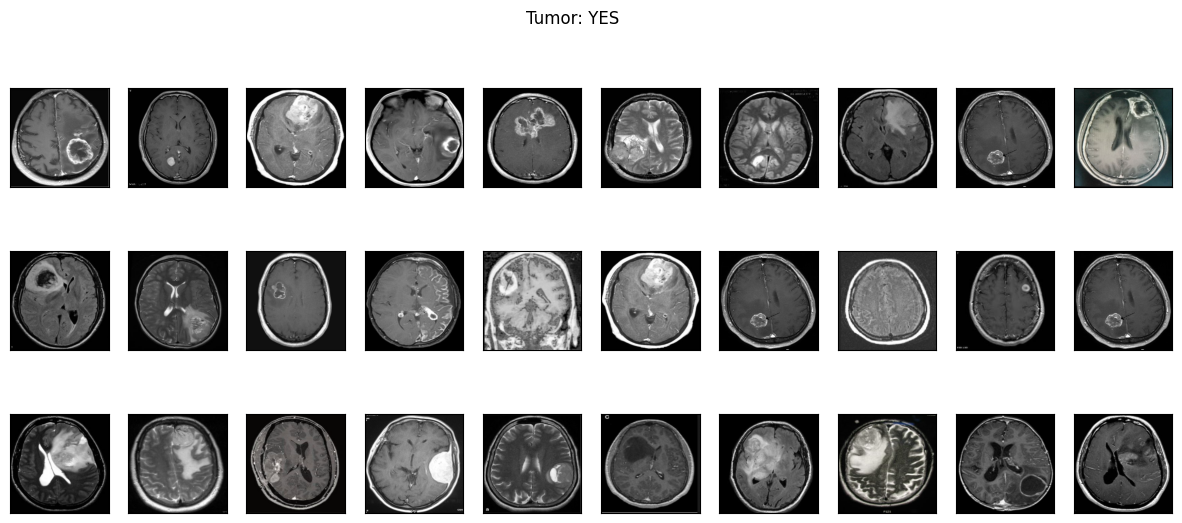

In [27]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

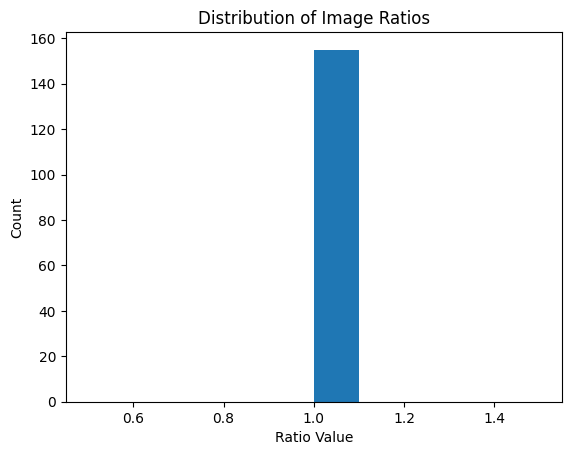

In [28]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [29]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [37]:
import os
import cv2

IMG_SIZE = (224, 224)  # Assuming this is defined elsewhere

# Get a list of image files in the directory
image_dir = '/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset/yes/'
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Load the first image in the list (or iterate through all images)
if image_files:
    img_path = os.path.join(image_dir, image_files[0])
    img = cv2.imread(img_path)

    # Proceed with resizing if image is loaded successfully
    if img is not None:
        img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
        # ... rest of your code ...
    else:
        print(f"Error: Could not load image from {img_path}")
else:
    print(f"Error: No image files found in {image_dir}")

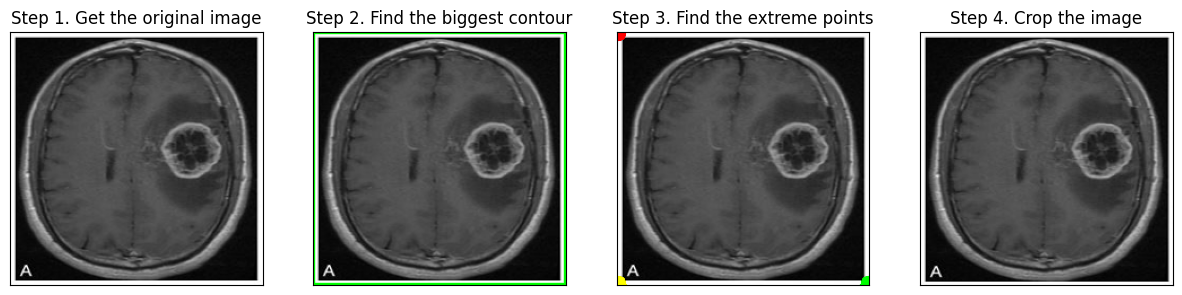

In [40]:
import os
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = (224, 224)  # Assuming this is defined elsewhere

# ... (crop_imgs function from ipython-input-29-aab12d0e0b8b) ...

# Get a list of image files in the directory
image_dir = '/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset/yes/'
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Load the first image in the list (or iterate through all images)
if image_files:
    img_path = os.path.join(image_dir, image_files[0])
    img = cv2.imread(img_path)

    # Proceed with resizing if image is loaded successfully
    if img is not None:
        img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )

        # Call crop_imgs function to create img_cnt, img_pnt, and new_img
        new_img = crop_imgs(np.array([img]))[0]  # Assuming crop_imgs expects a list of images

        # Placeholder for img_cnt and img_pnt - you'll need to
        # extract these from the crop_imgs function or create them separately
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 0), 2)

        # Assuming img_pnt is created by drawing extreme points on img
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        img_pnt = cv2.circle(img.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)
        # ... rest of your code ...
    else:
        print(f"Error: Could not load image from {img_path}")
else:
    print(f"Error: No image files found in {image_dir}")


plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [42]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        # Check if any contours were found
        if len(cnts) > 0:
            c = max(cnts, key=cv2.contourArea)

            # find the extreme points
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])

            ADD_PIXELS = add_pixels_value
            new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
            set_new.append(new_img)
        else:
            # If no contours are found, append the original image or handle it as needed
            set_new.append(img)

    return np.array(set_new, dtype=object) # Specify dtype=object to handle varying shapes

<Figure size 1500x600 with 0 Axes>

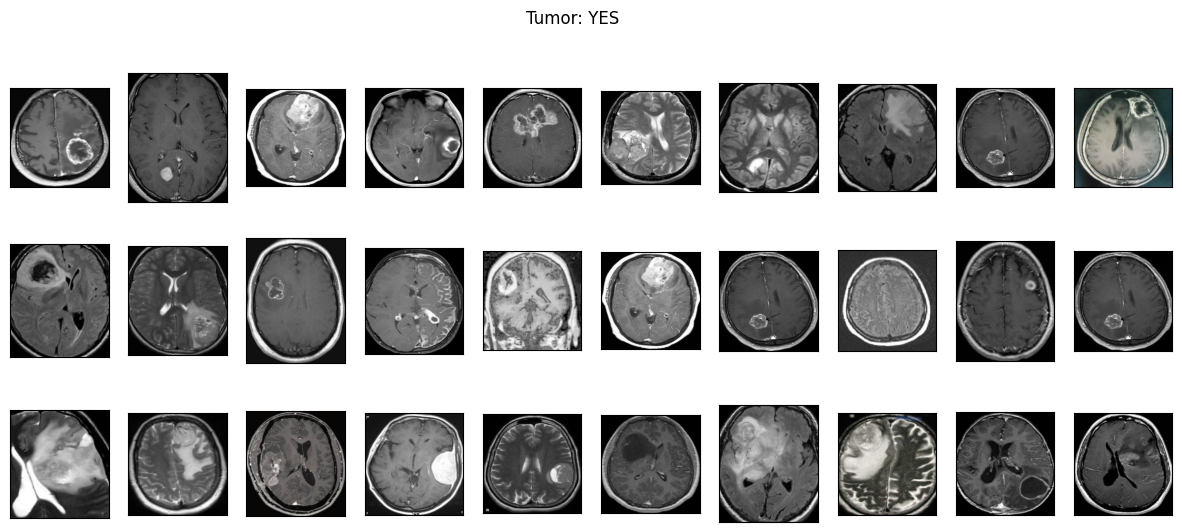

In [44]:
# Apply the crop_imgs function to the X_train dataset to create X_train_crop
X_train_crop = crop_imgs(X_train)

# Now call plot_samples with the X_train_crop variable
plot_samples(X_train_crop, y_train, labels, 30)

In [45]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [47]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
# Apply crop_imgs to X_val and store the result in X_val_crop
X_val_crop = crop_imgs(X_val)  # This line was missing
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
# Apply crop_imgs to X_test and store the result in X_test_crop
X_test_crop = crop_imgs(X_test)  # This line was missing
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [48]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [49]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

<Figure size 1500x600 with 0 Axes>

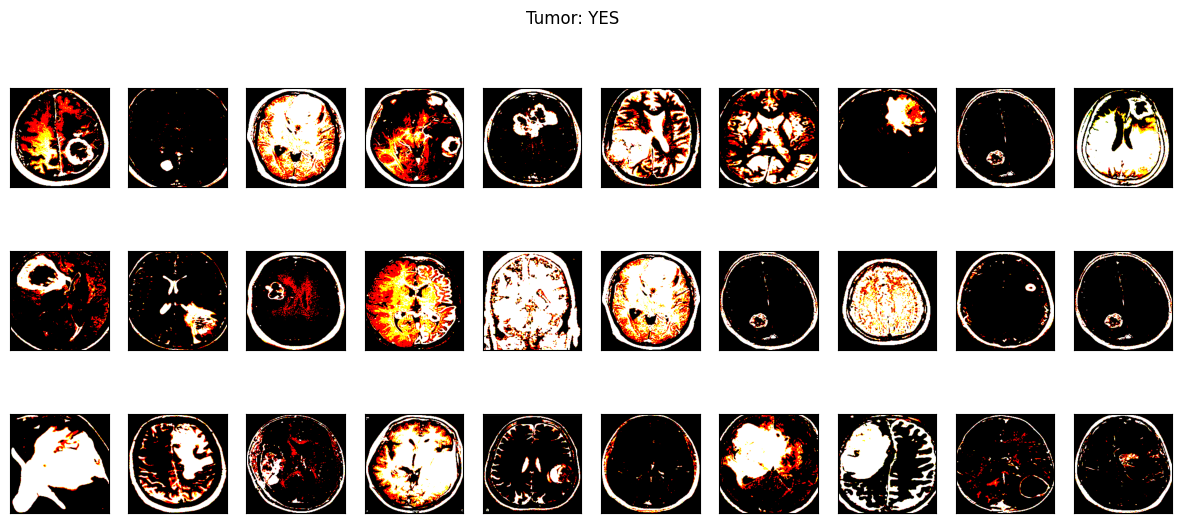

In [51]:
plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [52]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [53]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

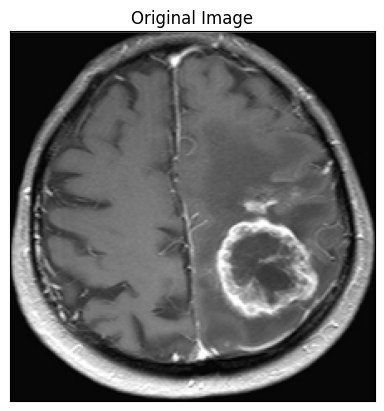

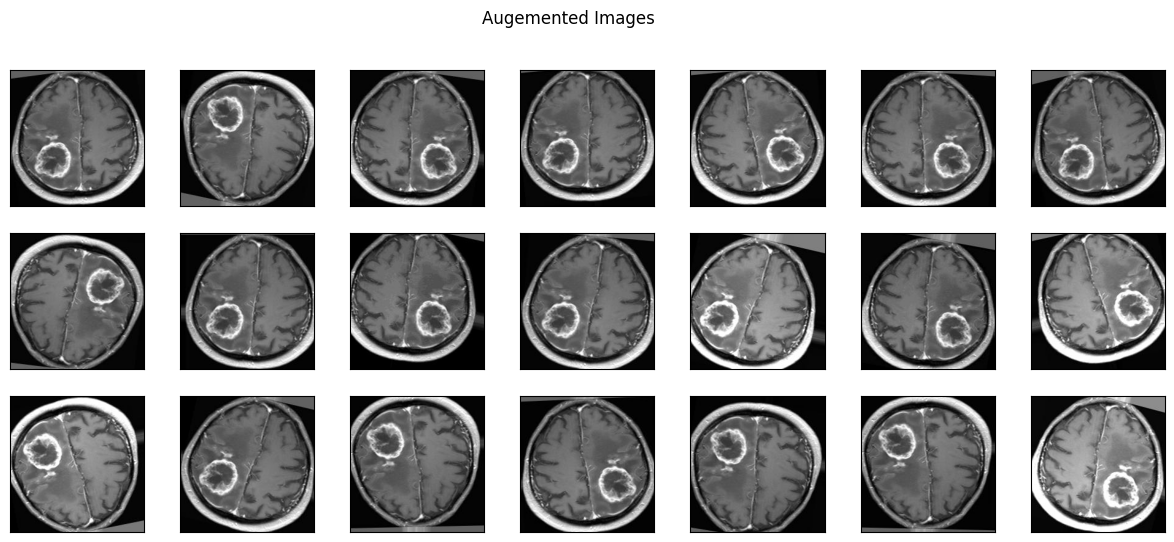

In [55]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    # Change cv2.cv2.imread to cv2.imread
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [56]:
!rm -rf preview/

### <a id='apply'>4.1.2. Apply</a>

In [57]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 119 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [59]:
# load base model
# Download the pre-trained weights
!mkdir -p /root/.keras/models
!wget -O /root/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 'https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

vgg16_weight_path = '/root/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' # Updated path
base_model = VGG16(
    weights=vgg16_weight_path, # Using the downloaded weights
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

--2025-02-13 14:27:18--  https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889256 (56M) [application/octet-stream]
Saving to: ‘/root/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5’

/root/.keras/models 100%[===================>]  56.16M   123MB/s    in 0.5s    

2025-02-13 14:27:19 (123 MB/s) - ‘/root/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [58889256/58889256]



In [61]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),  # Changed 'lr' to 'learning_rate'
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [64]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 1.0000 - loss: 5.7136e-09 - val_accuracy: 1.0000 - val_loss: 7.2495e-16
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 905ms/step - accuracy: 1.0000 - loss: 6.7363e-07 - val_accuracy: 1.0000 - val_loss: 7.0842e-16
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 1.0000 - loss: 2.1149e-07 - val_accuracy: 1.0000 - val_loss: 7.0137e-16
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 963ms/step - accuracy: 1.0000 - loss: 8.3206e-11 - val_accuracy: 1.0000 - val_loss: 7.0137e-16
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 900ms/step - accuracy: 1.0000 - loss: 1.6068e-08 - val_accuracy: 1.0000 - val_loss: 7.0083e-16
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 898ms/step - accuracy: 1.0000 - loss: 7.8411e-09 - val_accuracy: 1.0000 - val_loss: 7.0011e-16
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 970ms/step - accuracy: 1.0000 - loss: 2.5927e-09 - val_accuracy: 1.0000 - val_loss: 6.9998e-16
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 898ms

## <a id='perf'>4.3. Model Performance</a>

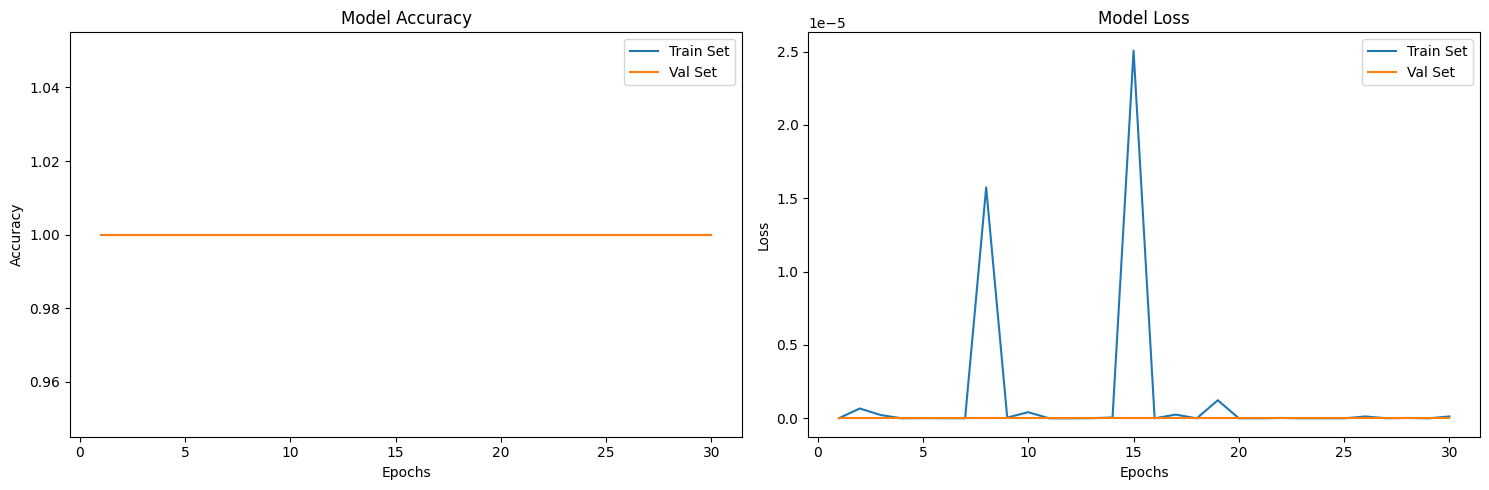

In [66]:
# plot model performance
acc = history.history['accuracy']  # Changed 'acc' to 'accuracy'
val_acc = history.history['val_accuracy']  # Changed 'val_acc' to 'val_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

# ... (rest of the plotting code remains the same)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Val Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.



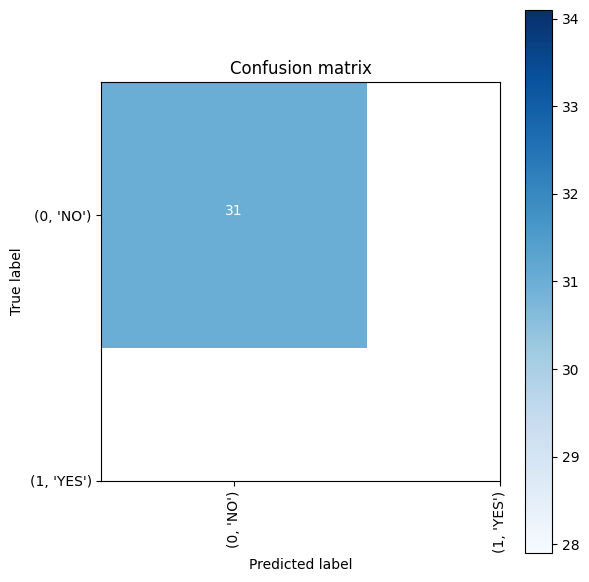

In [67]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test Accuracy = 0.00


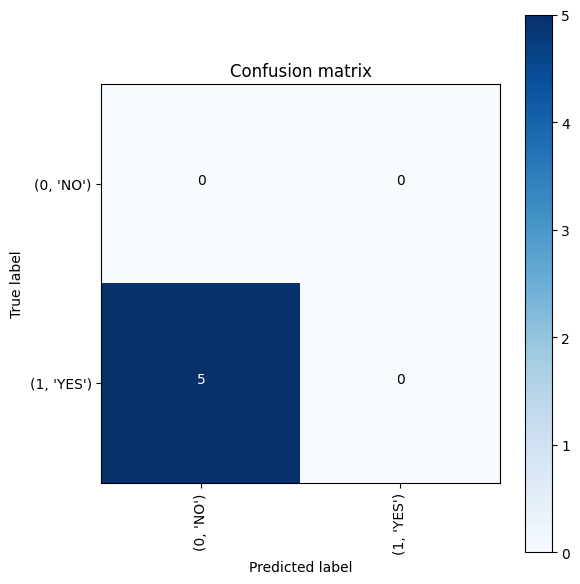

In [68]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

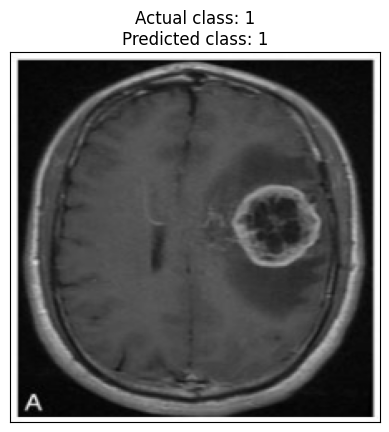

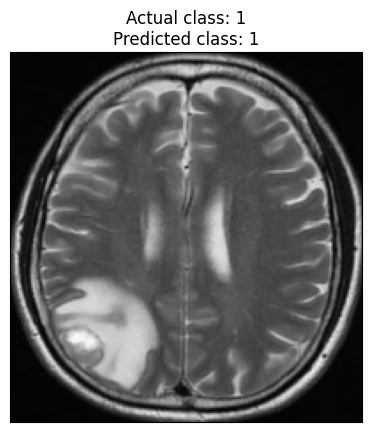

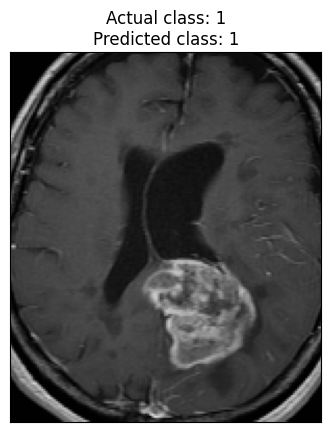

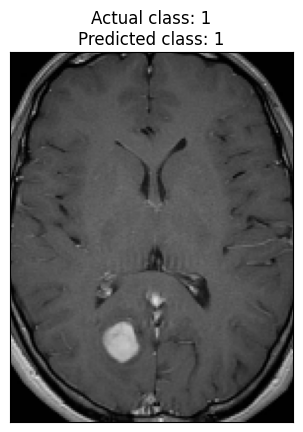

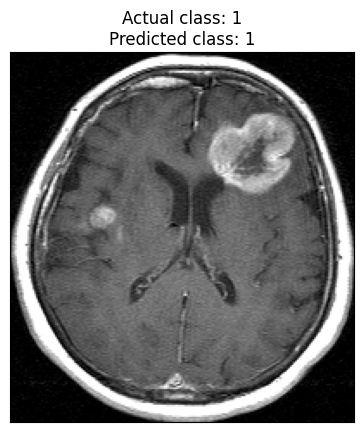

In [69]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

First scan looks a bit misleading - what is that light spot in the middle? 🤔 I can clearly see why model classified it as `Tumor`.

# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

In [70]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('2019-06-07_VGG_model.h5')